Imports

In [31]:
import time
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

Initialising variables and logging in

In [2]:
driver = webdriver.ChromiumEdge()
driver.get('https://www.instagram.com/')
username = 'sampleuser'
password = 'samplepass'

In [3]:
# logging in
driver.find_element(By.CSS_SELECTOR, "input[name = 'username']").send_keys(username)
driver.find_element(By.CSS_SELECTOR, "input[name = 'password']").send_keys(password) 
driver.find_element(By.CSS_SELECTOR,"button[type = 'submit']").click()

# closing popups
try:
    (WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div.cmbtv button')))).click()
    (WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div._a9-v button'))))[1].click()
except:
    pass

Some useful functions

In [4]:
# open profile of passed user profile name
def open_profile(profile_name):
    driver.get('https://www.instagram.com/'+profile_name)


# open post view of profile from most recent post
def open_post_view(profile_name):
    open_profile(profile_name)
    WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div._aa_m button')))[1]    # waiting profile page to load completely based on if follow button loaded or not
    driver.find_element(By.CSS_SELECTOR, 'article a').click()    # open most recent post


# go to next post
def next_post():
    try:
        driver.find_element(By.CSS_SELECTOR, 'div._aaqg._aaqh button').click()
    except:
        return 'Post view not open!'


#### **1. Follower and post statistics**

---

<br>

1. From first 10 handles found by searching 'food', finding the top 5 handles in terms of highest follower count.

2. Graphing the last 3 days post count of these handles.

In [5]:
def get_follower_count(profile_name):
    open_profile(profile_name)
    follower_count = (WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'ul._aa_7 li span'))))[1].get_attribute('title')
    return int(follower_count.replace(',', ''))

In [12]:
# finding the top 5
food_handles_follower_count = {}
with open('food_handles.txt') as text_file:    # food_handles.txt output from InstaBot1.ipynb
    for _ in range(10):
        food_handle = text_file.readline()[:-1]
        follower_count = get_follower_count(food_handle)
        food_handles_follower_count[food_handle] = follower_count

top_5_food_handles = sorted(food_handles_follower_count, key = lambda food_handle: food_handles_follower_count[food_handle], reverse=True)[:5]
for pos, handle in enumerate(top_5_food_handles):
    print(pos+1, handle, food_handles_follower_count[handle])

1 yourfoodlab 2003951
2 dilsefoodie 1024490
3 foodtalkindia 308099
4 food 180755
5 food_lunatic 136587


In [14]:
# finding post count of top 5
post_counts_by_handle = []    # each item is a list containing post count 1, 2, and 3 days old of corresponding handle in top_5_food_handles
for handle in top_5_food_handles:
    open_post_view(handle)
    post_counts = [0, 0, 0]

    while True:
        post_date = date.fromisoformat(((WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div._aa-b time')))).get_attribute('datetime')).split('T')[0])
        post_duration = (date.today() - post_date).days

        if post_duration == 0:
            pass

        elif post_duration == 1:
            post_counts[0] += 1

        elif post_duration == 2:
            post_counts[1] += 1

        elif post_duration == 3:
            post_counts[2] += 1

        else:
            break

        next_post()

    post_counts_by_handle.append(post_counts)

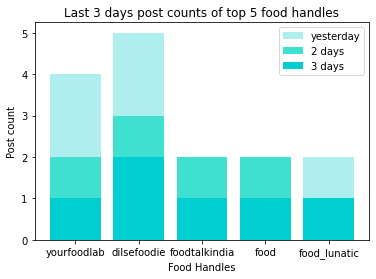

In [157]:
# plotting last 3 days post count
post_counts_by_duration = list(zip(*post_counts_by_handle))    # required for plotting purpose
x = np.arange(5)

# plotting stacked bar chart
p1 = plt.bar(x, post_counts_by_duration[2], color = 'darkturquoise')    # 3 days old posts
p2 = plt.bar(x, post_counts_by_duration[1], bottom = post_counts_by_duration[2], color = 'turquoise')    # 2 days old posts on top of 3 days old posts
p3 = plt.bar(x, post_counts_by_duration[0], bottom=np.array(post_counts_by_duration[1]) + np.array(post_counts_by_duration[2]), color = 'paleturquoise')   # 1 day old posts on top of 2 days old posts

plt.xlabel("Food Handles")
plt.ylabel('Post count')
plt.title('Last 3 days post counts of top 5 food handles')
plt.xticks(x, top_5_food_handles)
plt.yticks(list(range(max([sum(post_counts) for post_counts in post_counts_by_handle])+1)))
plt.legend((p3[0], p2[0], p1[0]), ('yesterday', '2 days', '3 days'))

plt.savefig('post_count.png')    # exporting the created figure as png
plt.show()

#### **2. Most popular hashtags**

---

<br>

1. From the obtained top 5 food handles, scrape the content of the first 10 posts.

3. Export word frequency csv from these posts.

2. Plot pie chart for 5 most popular hashtags based on thier frequncy of use.

In [96]:
words = {}    # word frequncy dictionary
tags = {}    # hashtag frequency dictionary

for handle in top_5_food_handles:
    open_post_view(handle)

    for _ in range(10):
        content = nltk.word_tokenize((WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div._a9zs span')))).text)    # tokenizing words in content
        i = 0
        flag = False    # flag for if word is a hashtag
        while i < len(content):
            word = content[i].replace('-', '')
            if word.isalpha():
                word = word.lower()
                if flag:
                    if word in tags:
                        tags[word] += 1
                    else:
                        tags[word] = 1
                    flag = False
                else:
                    if word in words:
                        words[word] += 1
                    else:
                        words[word] = 1
            # if words contains anything other than alphabets and hyphens
            else:
                if word == '@':    # if True next word assumed to be a username and hence skipped
                    i += 2
                    continue
                elif word == '#':    # if True next words assumed to be a hashtag and falg is set to True
                    flag = True
                else:    # for any other cases skip the
                    pass
            i += 1

        next_post()


In [108]:
# sorting and exporting scraped data
words = (pd.Series(words)).sort_values(ascending=False)
tags = (pd.Series(tags)).sort_values(ascending=False)
words.to_csv('words.csv', index_label = 'word', header = ['frequency'])
tags.to_csv('tags.csv', index_label = 'tag', header = ['frequency'])

<function matplotlib.pyplot.show(close=None, block=None)>

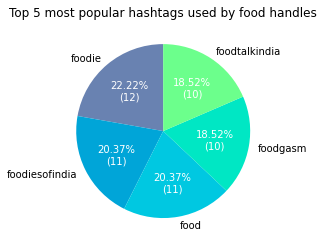

In [166]:
#plotting pie chart for top 5 most popular/frequent hashtags
colors = ('#6982b1', '#00a5d8', '#00c8e1', '#00e7c4', '#6cff8c')
patches, texts, autotexts = plt.pie(tags[:5], labels = tags.keys()[:5], startangle=90, autopct = lambda frequency: f'{frequency:.2f}%\n({round((frequency/100)*sum(tags[:5]))})' , colors= colors)
for autotext in autotexts:
    autotext.set_color('white')
plt.title('Top 5 most popular hashtags used by food handles')
plt.savefig('popular_hashtag.png')
plt.show

#### **3. Average followers to likes ratio**

---

<br>

1. From the obtained top 5 food handles, calculate average likes for the first 10 posts.

3. Divide average likes by followers to get the reuired ratio for each handle

2. Plot bar graph for above information

In [144]:
# get no. of likes of current open post
def get_likes():
    try:
        likes = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'section._aa-7 span')))
    except:
        raise ValueError    # cannot find given likes section
    if len(likes) == 4:
        likes = int(likes[3].text.replace(',', '')) + 1    # if section format like: liked by <user> and <n> others. Get n and add 1 for total no. of likes
    elif len(likes) == 1:
        likes = int(likes[0].text.replace(',', ''))    # otherwise simply extract the total no. of likes given as text
    else:    # in this case instagram show no. of views instead and not likes or some other unexpected error
        raise ValueError   
    return likes

In [145]:
avg_follower_like_ratio = {}

for handle in top_5_food_handles:
    open_post_view(handle)
    total_likes = 0
    i = 0
    while i <= 10:
        try:
            total_likes += get_likes()
        except ValueError:    # if no. of views present instead of likes/cannot get likes, skip that post
            next_post()
            continue
        i += 1
        next_post()
    avg_follower_like_ratio[handle] = (total_likes/10)/(food_handles_follower_count[handle])

<function matplotlib.pyplot.show(close=None, block=None)>

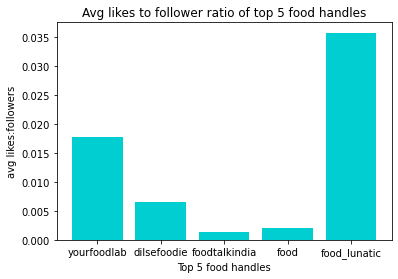

In [162]:
plt.bar(np.arange(5), avg_follower_like_ratio.values(), color = 'darkturquoise')
plt.title('Avg likes to follower ratio of top 5 food handles')
plt.xlabel('Top 5 food handles')
plt.ylabel('avg likes:followers')
plt.xticks(np.arange(5), top_5_food_handles)
plt.savefig('avg_likes_to_followers.png')
plt.show